# Prediksi Harga Rumah dengan Random Forest Regressor
Dhia Salsabila Azhar

dhia.s.a.@member.maribelajar.org


# Import Library

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.model_selection import cross_validate, KFold
from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import learning_curve as curves
from time import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score, max_error, make_scorer

# Load dataset

In [2]:
df = pd.read_csv('MariBisnis.csv')

# Visualisasi data

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
df.shape

(21613, 21)

In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Check Missing Value

In [6]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [7]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(df)

,Total,Percent
sqft_lot15,0,0.0
view,0,0.0
date,0,0.0
price,0,0.0
bedrooms,0,0.0
bathrooms,0,0.0
sqft_living,0,0.0
sqft_lot,0,0.0
floors,0,0.0
waterfront,0,0.0


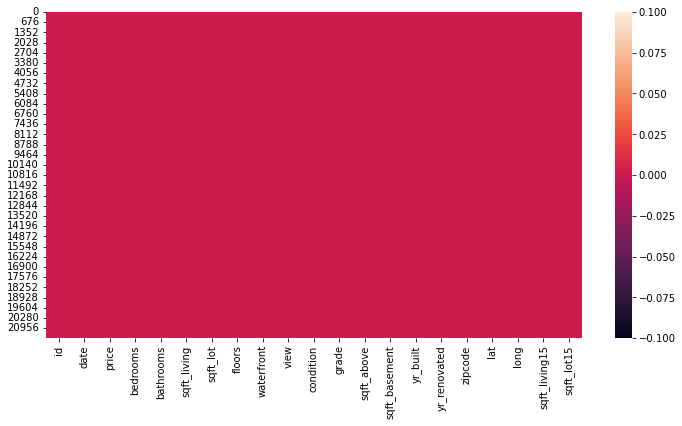

In [8]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull())
plt.show()

# Correlation antara atribute data train

Untuk mengetahui korelasi perlu mengetahui data numerik dan kategorik

In [9]:
# Mengetahui nilai unik pada tiap kolom data

for col in df.columns:
    print('unique value', col, 'is')
    print(df[col].value_counts())
    print('\n')

unique value id is
795000620     3
2206700215    2
643300040     2
3333002450    2
1995200200    2
             ..
3420069065    1
7812801125    1
4364700875    1
3021059276    1
1777500160    1
Name: id, Length: 21436, dtype: int64


unique value date is
20140623T000000    142
20140626T000000    131
20140625T000000    131
20140708T000000    127
20150427T000000    126
                  ... 
20140727T000000      1
20141102T000000      1
20150515T000000      1
20150524T000000      1
20150308T000000      1
Name: date, Length: 372, dtype: int64


unique value price is
450000.0    172
350000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
641500.0      1
575950.0      1
674250.0      1
608700.0      1
884744.0      1
Name: price, Length: 4028, dtype: int64


unique value bedrooms is
3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64


unique value

In [10]:
column = ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']

numeric = ['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors','sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated','lat', 
           'long', 'sqft_living15', 'sqft_lot15']

df[numeric].describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


Preprocessing data (Data Transformasi)


In [11]:
# ceiling floors and bathrooms
df["bathrooms"] = np.round(df.bathrooms)
df["floors"] = np.round(df.floors)

# add new column renovated from yr_renovated
renovated = []
for x in df["yr_renovated"] :
    if x == 0:
        x=0
    else :
        x=1
    renovated.append(x)
df["renovated"] = np.array(renovated)

# add new column basement from sqft_basement
basement = []
for x in df["sqft_basement"] :
    if x == 0:
        x=0
    else :
        x=1
    basement.append(x)
df["basement"] = np.array(basement)

# add new column age_of_building, yr_sold, month_sold
from datetime import datetime
import calendar

df['date'] = df['date'].str.split('T').str[0]

months = []
years = []
for x in df.date :
    datetime_object = datetime.strptime(x, '%Y%m%d')
    month = datetime_object.month
    month = calendar.month_name[month]
    year = datetime_object.year
    months.append(month)
    years.append(year)

df["yr_sold"] = np.array(years)
df["month_sold"] = np.array(months)
df["age_of_building"] = df["yr_sold"] - df["yr_built"]

In [12]:
# Memisahkan kolom numerik dan kategorik
numeric = ['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors','sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated','lat', 'long', 'sqft_living15', 'sqft_lot15','age_of_building','yr_sold']

categoric = ["grade","view","basement","renovated","condition","zipcode","waterfront","price"]

df_numeric = df[numeric]
df_categoric = df[categoric]

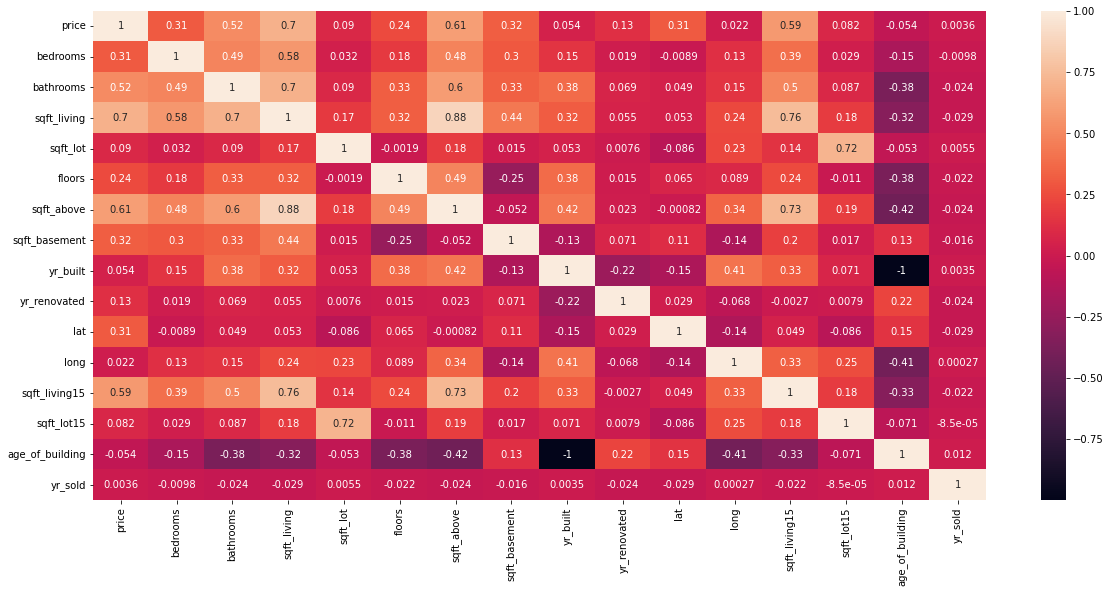

In [13]:
# Korelasi kolom price dengan kolom numerik

corr = df_numeric.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr, annot=True)

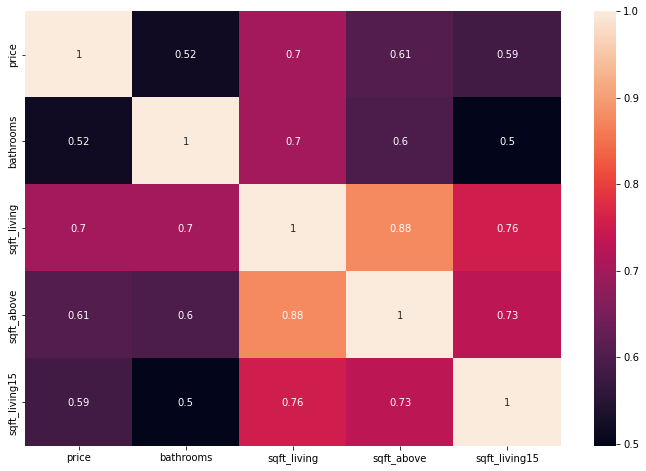

In [14]:
# Kolom yang memiliki korelasi > 50%

top_feature = corr.index[abs(corr['price']>0.5)]
plt.subplots(figsize=(12, 8))
top_corr = df_numeric[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

In [15]:
data_corr = pd.DataFrame((abs(df_numeric.corr()['price']).sort_values(ascending = False)))
data_corr = data_corr.reset_index()
data_corr = data_corr.drop(data_corr[data_corr.price == 1].index)
data_corr = data_corr.rename({'price': 'value'}, axis=1)
data_corr

,index,value
1,sqft_living,0.702035
2,sqft_above,0.605567
3,sqft_living15,0.585379
4,bathrooms,0.518912
5,sqft_basement,0.323816
6,bedrooms,0.308350
7,lat,0.307003
8,floors,0.244906
9,yr_renovated,0.126434
10,sqft_lot,0.089661


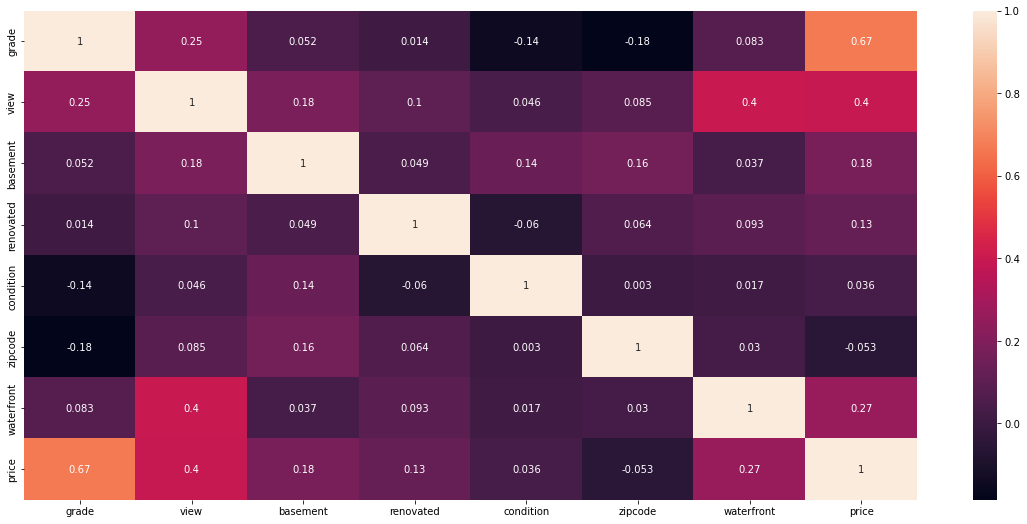

In [16]:
# Korelasi kolom price dengan kolom kategorik

corr = df_categoric.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr, annot=True)

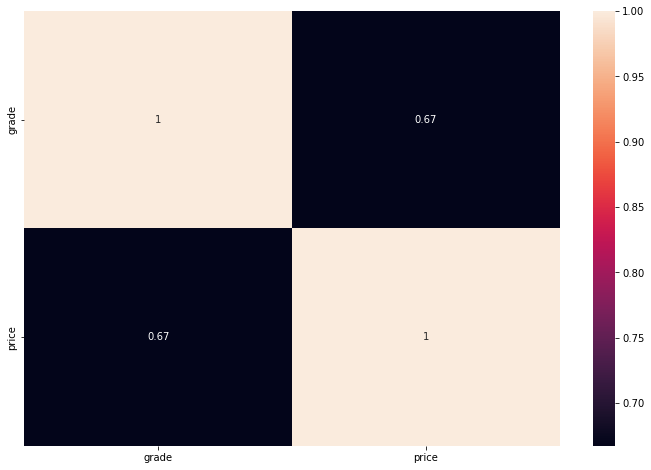

In [17]:
# Kolom kategorik yang memiliki korelasi > 50%

top_feature = corr.index[abs(corr['price']>0.5)]
plt.subplots(figsize=(12, 8))
top_corr = df_categoric[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

In [18]:
data_corr = pd.DataFrame((abs(df_categoric.corr(method='kendall')['price']).sort_values(ascending = False)))
data_corr = data_corr.reset_index()
data_corr = data_corr.drop(data_corr[data_corr.price == 1].index)
data_corr = data_corr.rename({'price': 'value'}, axis=1)
data_corr

,index,value
1,grade,0.527834
2,view,0.237573
3,basement,0.167626
4,waterfront,0.094069
5,renovated,0.082575
6,condition,0.014481
7,zipcode,0.009827


# EDA or Data Visualization

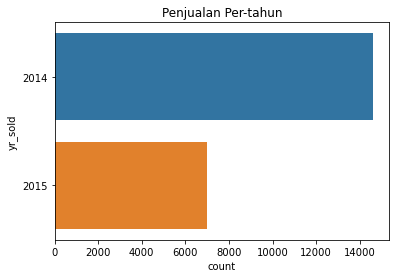

In [19]:
sns.countplot(y ='yr_sold', data = df,order = df["yr_sold"].value_counts().index)
plt.title("Penjualan Per-tahun")
plt.show()

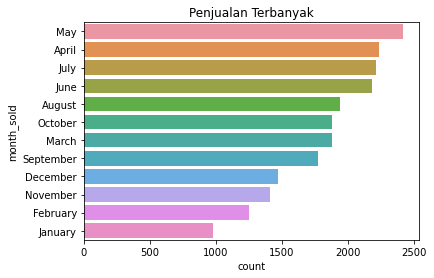

In [20]:
sns.countplot(y ='month_sold', data = df,order = df["month_sold"].value_counts().index)
plt.title("Penjualan Terbanyak")
plt.show()

<Figure size 864x432 with 0 Axes>

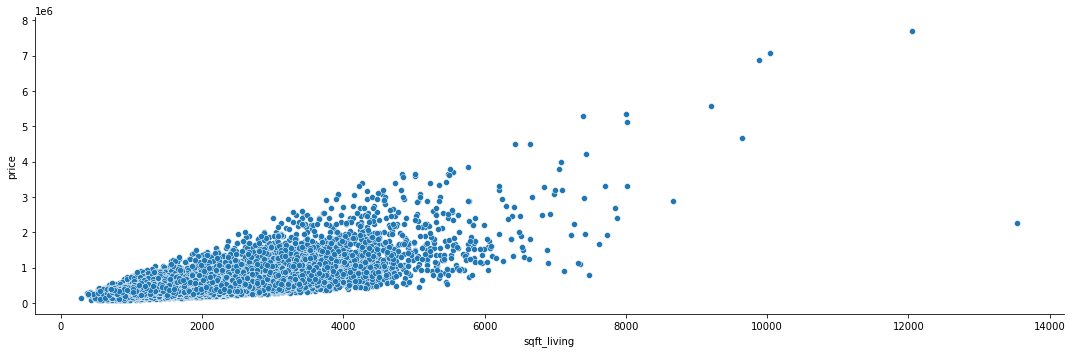

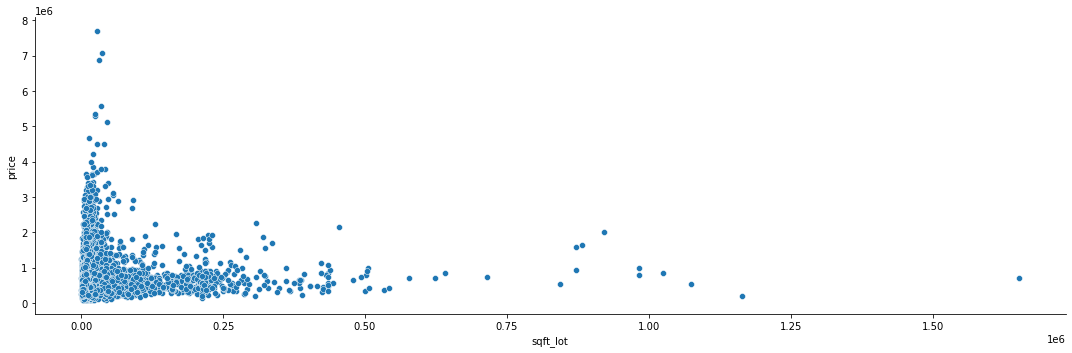

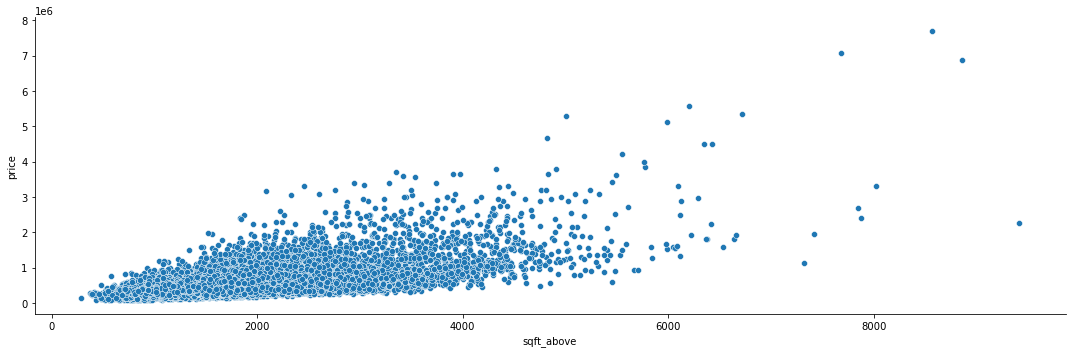

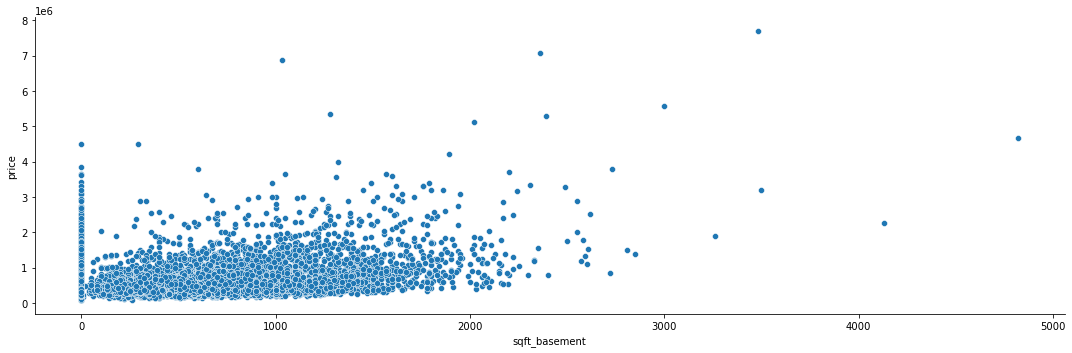

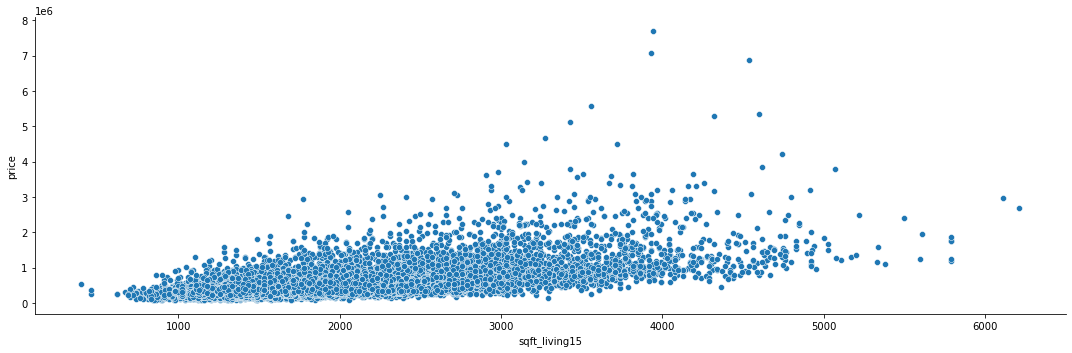

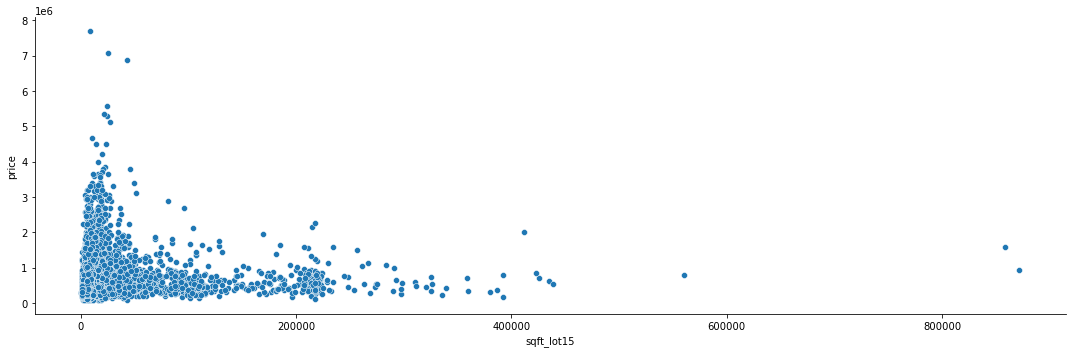

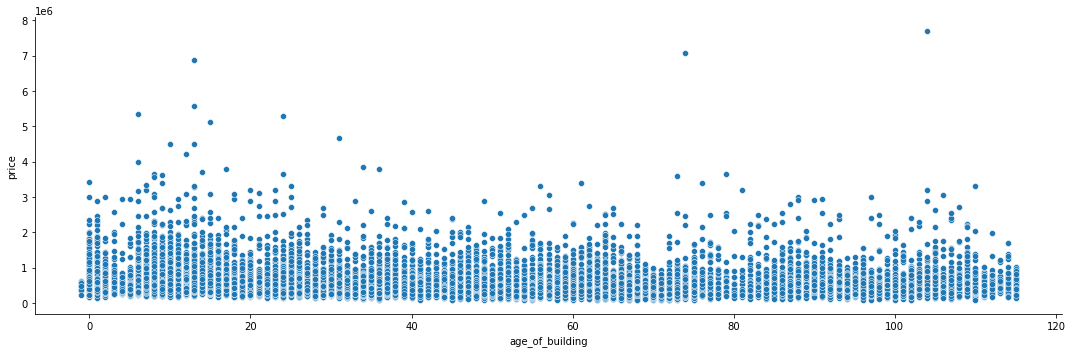

In [21]:
plt.figure(figsize=(12, 6))
for numerical_feature in ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_of_building']:
    sns.relplot(kind='scatter', y='price', x=numerical_feature, data=df, aspect=3)

<Figure size 864x432 with 0 Axes>

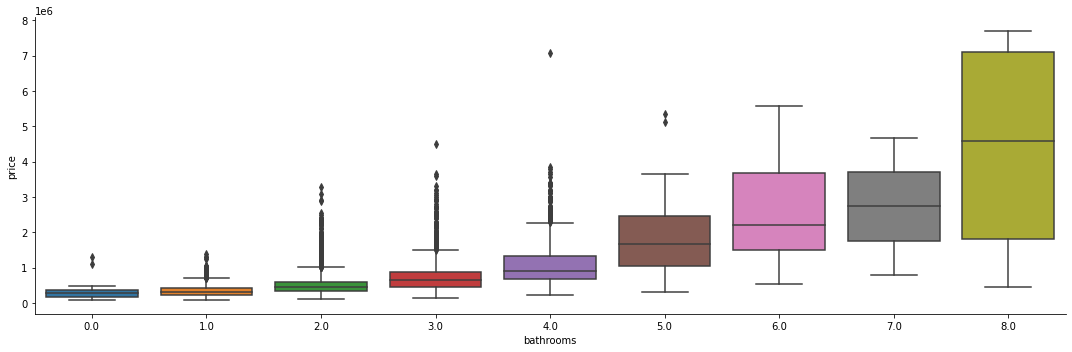

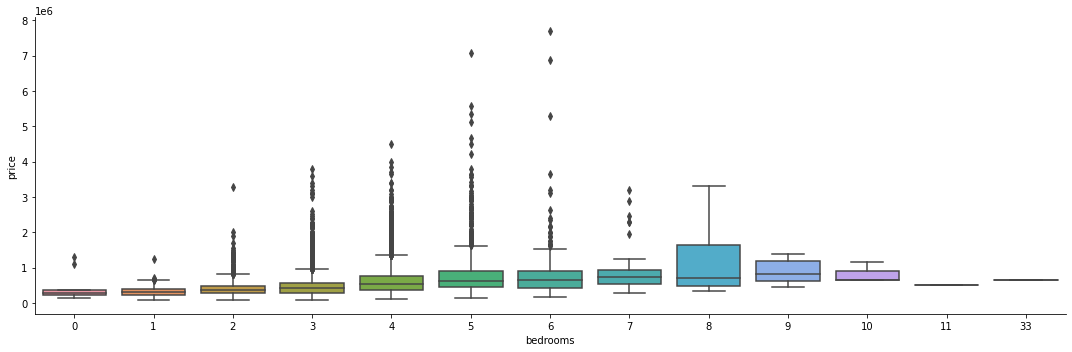

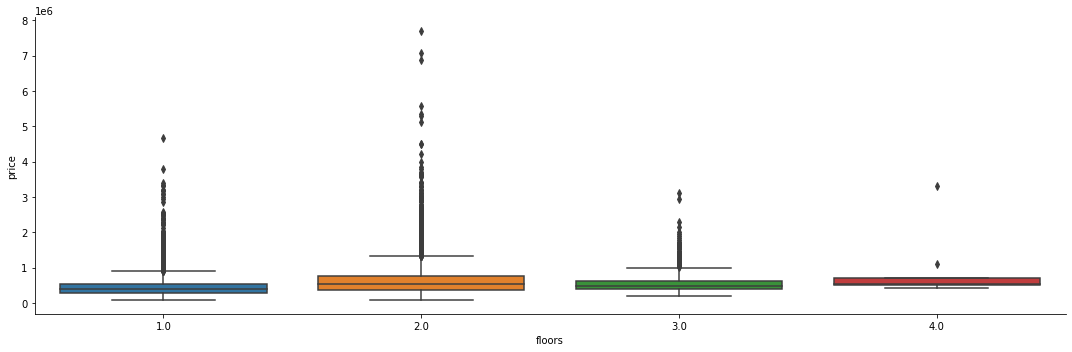

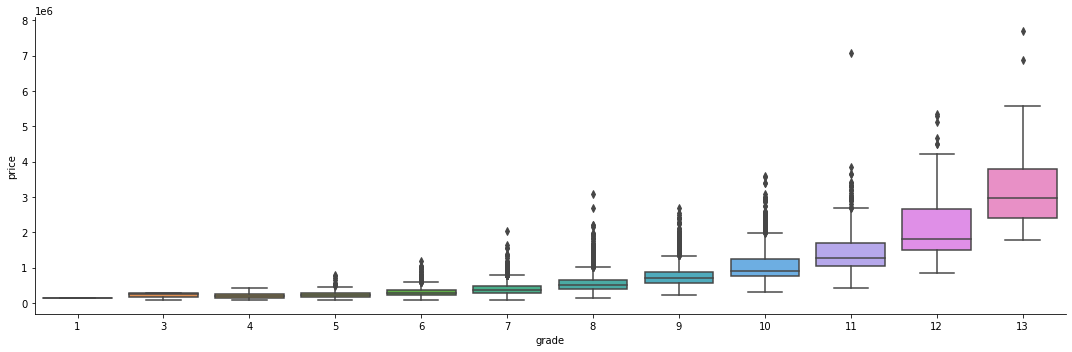

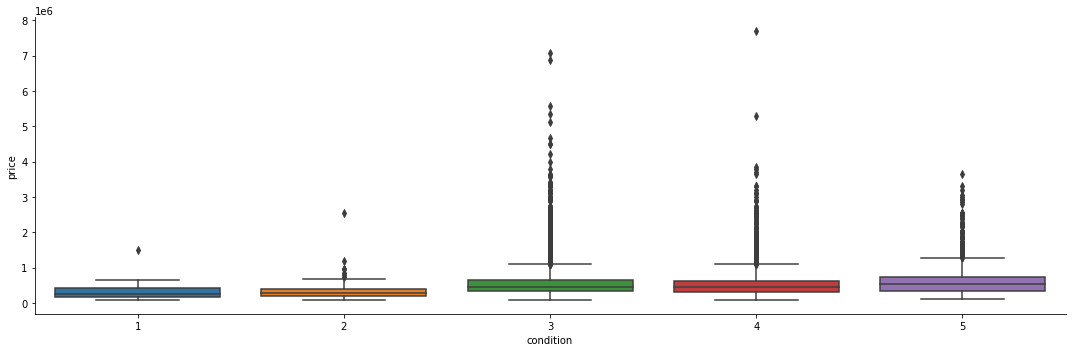

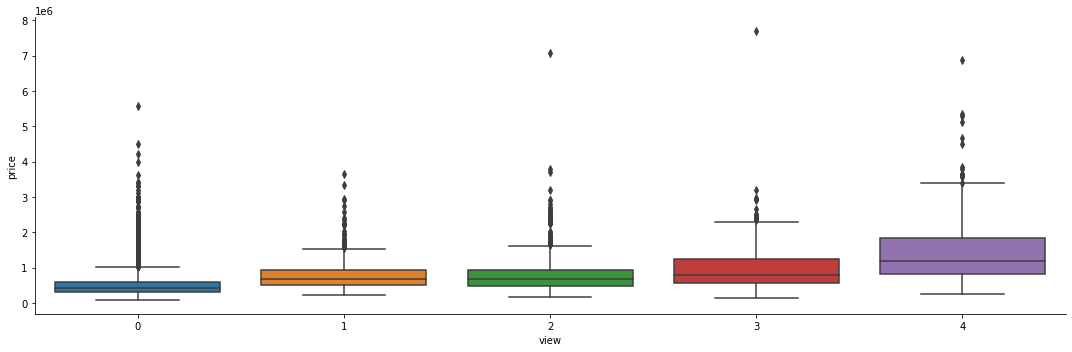

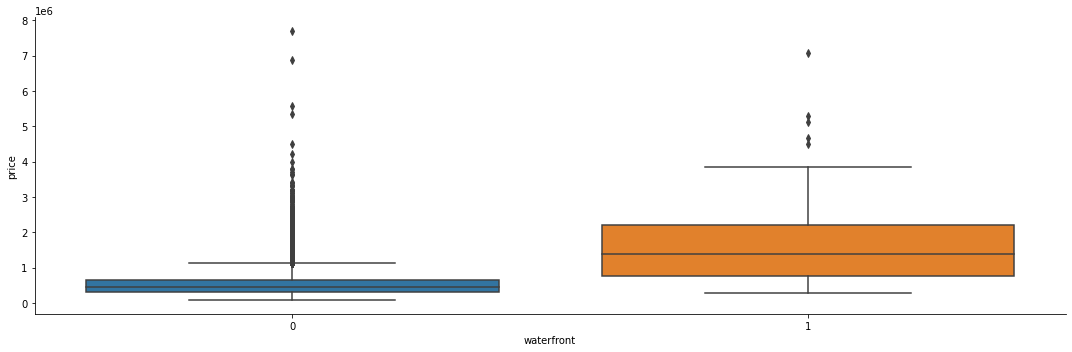

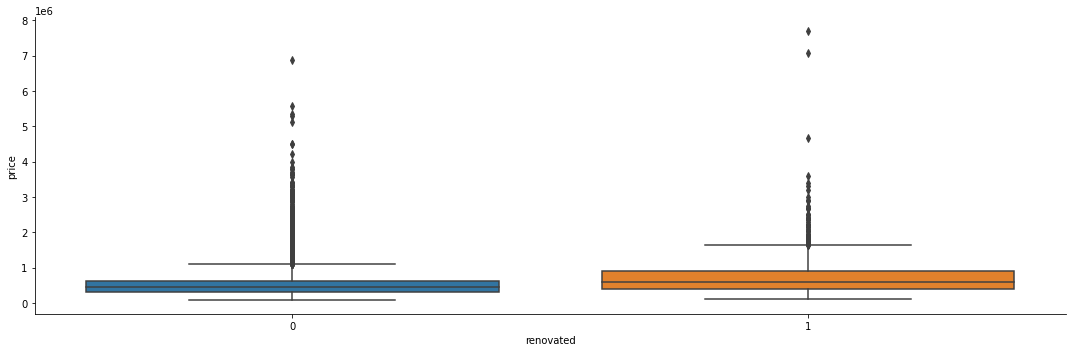

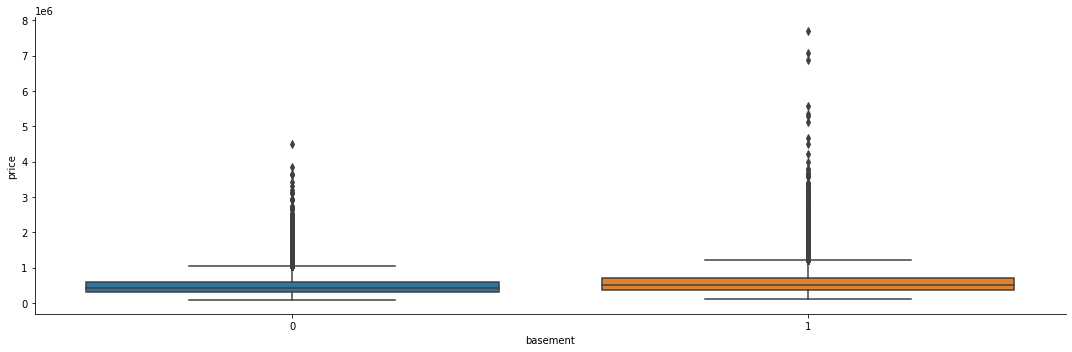

In [22]:
plt.figure(figsize=(12, 6))
for categorical_feature in ['bathrooms', 'bedrooms', 'floors', 'grade', 'condition', 'view', 'waterfront', 'renovated', 'basement']:
    sns.catplot(kind='box', y='price', x=categorical_feature, data=df, aspect=3)

# save new dataset

In [23]:
df.to_csv("MariBisnisTransformated.csv",index=False)

# Split data untuk training dan testing

In [24]:
new_data = df[["sqft_living15","sqft_living","sqft_above","sqft_basement","bathrooms","bedrooms","floors","grade","view","basement","waterfront","renovated","price","lat","long"]]
X = new_data.drop(columns="price")
y = df['price']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

# Applying Machine Learning Model

Menggunakan Model Random Forest Regressor

In [26]:
from sklearn.ensemble import RandomForestRegressor

rand_regr = RandomForestRegressor(n_estimators=400,random_state=0)
start = time()
rand_regr.fit(X_train, y_train)
end=time()
train_time_rand=end-start
random=rand_regr.score(X_test,y_test)
train_pred = rand_regr.predict(X_train)
test_pred = rand_regr.predict(X_test)
exp_rand = explained_variance_score(test_pred,y_test)

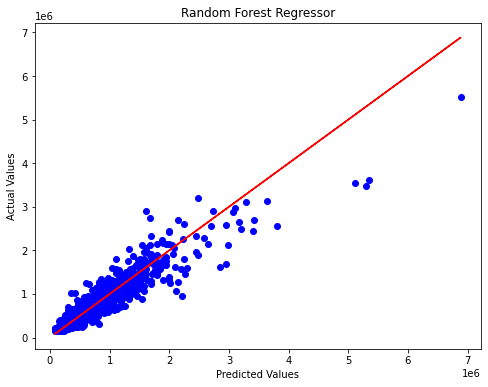

In [27]:
fig, ax1 = plt.subplots(figsize=(8,6))
plt.scatter(y_test,test_pred,color='blue')
plt.plot(y_test,y_test,color='red')
plt.title('Random Forest Regressor')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

# Evaluasi Model

In [28]:
print("Training MAE:\n")
print(mae(y_train, train_pred))

print("\n\nTesting MAE:\n")
print(mae(y_test, test_pred))

Training MAE:

26994.27476312699


Testing MAE:

71095.50564331244


In [29]:
print("Training Maximum Error:\n")
print(max_error(y_train, train_pred))

print("\n\nTesting Maximum Error:\n")
print(max_error(y_test, test_pred))

Training Maximum Error:

1130781.625


Testing Maximum Error:

1819608.6


In [30]:
print("Training R2_Score:\n")
print(r2_score(y_train, train_pred))

print("\n\nTesting R2_Score:\n")
print(r2_score(y_test, test_pred))

Training R2_Score:

0.9819242124172288


Testing R2_Score:

0.882187222203108


# Evaluasi Model dengan Cross-Validation

In [31]:
scoring = {'MSE' : make_scorer(mean_squared_error),
           'MAE' : make_scorer(mae),
           'R2' : make_scorer(r2_score)
          }
kfold = KFold(n_splits=5, random_state=1234, shuffle = True)
results_reg = cross_validate(estimator=rand_regr,X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)
results_reg

{'fit_time': array([44.96476364, 44.6780746 , 44.27600527, 44.45060277, 44.67111325]),
 'score_time': array([0.60170937, 0.60086632, 0.60120034, 0.60293102, 0.599576  ]),
 'test_MSE': array([1.74430337e+10, 1.66380062e+10, 1.84989063e+10, 1.62610810e+10,
        1.45793440e+10]),
 'test_MAE': array([71310.4375223 , 71395.52927847, 74768.28130472, 71593.76375653,
        68409.27366784]),
 'test_R2': array([0.86736987, 0.87661872, 0.86904289, 0.87732731, 0.89091801])}

In [32]:
rmse = np.sqrt(results_reg.get('test_MSE'))
mae = (results_reg.get('test_MAE'))
r2 = (results_reg.get('test_R2'))
print('mean_RMSE : ', "%.15f" % (rmse.mean()))
print('mean_MAE : ', "%.15f" % (mae.mean()))
print('mean_R2 : ', "%.15f" % (r2.mean()))

mean_RMSE :  129067.011211088887649
mean_MAE :  71495.457105972294812
mean_R2 :  0.876255360644725
